In [ ]:
%pip install git+https://github.com/fra31/auto-attack

In [3]:
import torch
import numpy as np

from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data.dataloader import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [4]:
from tqdm import tqdm

def train(model, optmz, crtrn, dl):
    model.train()
    
    loss = 0
    for images, labels in tqdm(dl):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images).squeeze()
        b_loss = crtrn(output, labels)
        
        optmz.zero_grad()
        b_loss.backward()
        optmz.step()
        
        loss += b_loss.item()
    
    return loss

@torch.no_grad()
def eval(model, eps, dl):
    model.eval()

    from autoattack import AutoAttack
    attack = AutoAttack(model, norm='Linf', eps=eps)
    
    total, n_correct, n_certify, n_robustd = 0, 0, 0, 0
    for images, labels in tqdm(dl):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images).squeeze()
        predic = torch.max(output, dim=1)
        second = torch.kthvalue(output, 9, dim=1)
        correct = predic.indices == labels
        certify = correct.logical_and(predic.values - second.values > eps)

        # output = attack.apgd.perturb(images, labels)
        # predic = model(output).squeeze()
        # predic = torch.max(predic, dim=1)
        # robustd = predic.indices == labels

        total += labels.size(0)
        n_correct += correct.sum().item()
        n_certify += certify.sum().item()
        # n_robustd += robustd.sum().item()

    return n_correct / total, n_certify / total, n_robustd / total

In [10]:
import torch.nn as nn
import Lipschitz.nn as Ln

class MLP(nn.Module):
    def __init__(self, widths, Linear, Mean):
        super().__init__()
        self.widths = widths

        self.linears = nn.ModuleList([Linear(width, next) for (width, next) in zip(widths, widths[1:])])
        self.means = nn.ModuleList([Mean(width) for width in widths[1:]])

    def forward(self, inputs, depth=None, **args):
        length = len(self.widths) if depth is None else depth
        for layer, mean in zip(self.linears[:length], self.means[:length]):
            inputs = mean(layer(inputs.flatten(1), **args))
        return inputs

class LpNet(MLP):
    def __init__(self, widths):
        super().__init__(widths, Ln.Linear, Ln.BatchMean)

class Net(MLP):
    def __init__(self, net, depth):
        super().__init__(net.widths[depth:], nn.Linear, nn.BatchNorm1d)
        self.net = net
        self.depth = depth
    
    def forward(self, inputs, **args):
        inputs = self.net.forward(inputs, self.depth, **args)
        return super().forward(inputs, **args)

def train_depth(lpnet, depth, epoches):
    net = Net(lpnet, depth).to(device)
    optmz = torch.optim.Adam(net.parameters(), 1e-2)
    crtrn = torch.nn.CrossEntropyLoss()

    for epoch in range(epoches):
        loss = train(net, optmz, crtrn, dataloader)
        if epoch % 10 == 0:
            accu = eval(net, 8/255, dataloader)
            print(f'Epoch {epoch+1} average loss: {loss}, accuracy: {accu}')
        else:
            print(f'Epoch {epoch+1} average loss: {loss}')

lpnet = LpNet([28*28, 1024, 512, 128, 10]).to(device)
train_depth(lpnet, 1, 100)

  1%|▏         | 3/235 [00:05<06:59,  1.81s/it]


KeyboardInterrupt: 

100%|██████████| 1000000/1000000 [00:24<00:00, 41159.32it/s]


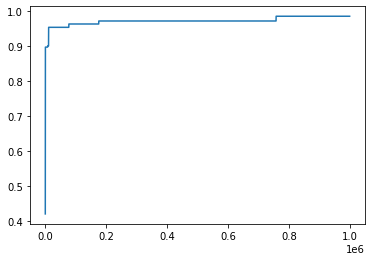

In [104]:
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

def norm(x, p):
    return x.pow(p).sum().pow(1/p)

def calc(p, d):
    while True:
        w, x = torch.rand(d), torch.rand(d)
        delta = torch.rand(d)

        fx = norm(w*x, p)
        fx_delta = norm(w*(x+delta), p)

        lipschitz = norm(w, p)
        distance_x = norm(delta, p)
        distance_fx = torch.abs(fx_delta - fx)

        return distance_fx / distance_x, lipschitz

def work(p, nsample, color):
    xs, ys = [], []
    for d in tqdm(range(1, 20)):
        m = 0
        for _ in range(nsample):
            s, l = calc(p, d)
            if l != 0:
                m = max(m, s / l)
        xs.append(d), ys.append(m)

    plt.plot(xs, ys, c=color)

# work(5, 1000, "green")
# work(5, 10000, "blue")
# work(5, 20000, "blue")
# work(5, 30000, "blue")
# work(5, 40000, "blue")
# work(5, 50000, "blue")
# work(5, 60000, "blue")
# work(5, 70000, "blue")


n = 1000000
m, ms = 0, []
for _ in tqdm(range(n)):
    s, l = calc(5, 10)
    if l != 0:
        m = max(m, s / l)
    ms.append(m)

plt.plot(range(n), ms)

# p, d = 50, 6
# X, Y = [], []
# for _ in tqdm(range(10000)):

#     X.append(distance_fx / distance_x)
#     Y.append(lipschitz)

#     if distance_fx / distance_x > lipschitz + 1e-8:
#         print(w, x, delta)
#         break

# lim = [0, 2]
# plt.scatter(X, Y, s=1)
# plt.plot(lim, lim, c="red")
# plt.xlim(*lim)
# plt.ylim(*lim)

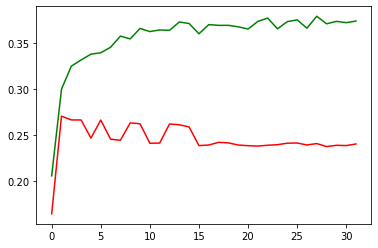

In [3]:
import matplotlib.pyplot as plt

plt.plot(
    range(32),
    [0.16483333333333333, 0.27086666666666664, 0.26676666666666665, 0.2667, 0.24708333333333332, 0.26661666666666667, 0.24588333333333334, 0.2447, 0.26353333333333334, 0.26263333333333333, 0.24148333333333333, 0.24163333333333334, 0.2623, 0.2615166666666667, 0.2591333333333333, 0.23886666666666667, 0.23955, 0.24245, 0.24191666666666667, 0.23953333333333332, 0.23883333333333334, 0.2384, 0.23928333333333332, 0.23993333333333333, 0.24151666666666666, 0.24175, 0.23958333333333334, 0.24111666666666667, 0.23788333333333334, 0.23921666666666666, 0.23895, 0.24068333333333333],
    c="red",
)

plt.plot(
    range(32),
    [0.20611666666666667, 0.3, 0.32506666666666667, 0.3317833333333333, 0.33808333333333335, 0.33953333333333335, 0.34555, 0.3576166666666667, 0.3546166666666667, 0.36595, 0.36256666666666665, 0.36435, 0.36386666666666667, 0.37296666666666667, 0.37128333333333335, 0.36013333333333336, 0.37011666666666665, 0.36928333333333335, 0.3693166666666667, 0.36773333333333336, 0.3653166666666667, 0.37356666666666666, 0.3772, 0.36555, 0.3733166666666667, 0.37528333333333336, 0.36625, 0.3791833333333333, 0.37098333333333333, 0.3736333333333333, 0.37221666666666664, 0.37398333333333333],
    c="green",
)